In [1004]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.discriminant_analysis import StandardScaler
import numpy as np

In [1005]:
def load_dataset(columns_drop) -> tuple([pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]):
    train = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\train.csv")
    greeks = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\greeks.csv")
    test = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\test.csv")
    columns_drop = ['Id'] + columns_drop
    id_list = test["Id"]
    train.drop(columns_drop, inplace=True, axis=1)
    test.drop(columns_drop, inplace=True, axis=1)
    print(len(train.columns))
    return (train, greeks, test, id_list)

In [1006]:
def split_data(df: pd.DataFrame, split)->tuple([pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]):
    X = df.loc[:, df.columns != "Class"]
    y = df.loc[:, "Class"]
    return train_test_split(X, y, test_size=split, random_state=42)

In [1007]:
def build_pipeline(df: pd.DataFrame) -> ColumnTransformer:
    # Preprocessing for numerical data    
    numerical_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant')),
        ('scaler', StandardScaler())])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Bundle preprocessing for numerical and categorical data
    numerical_cols = [cname for cname in df.columns if df[cname].dtype in ["int64", "float64"]]
    categorical_cols = [cname for cname in df.columns if df[cname].nunique() < 10]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    print(f"Number of columns: {len(df.columns)}")
    return preprocessor

In [1008]:
# Define model
#model = RandomForestClassifier(n_estimators=100, random_state=22)
model = XGBClassifier(n_estimators=500)

#Splitting
train, greeks, test, id_list = load_dataset(columns_drop=[])
print(f"dataset shape: {train.shape}")
X_train, X_valid, y_train, y_valid = split_data(train, 0.3)
print(f"X shape: {X_train.shape} and y shape: {y_train.shape}")

57
dataset shape: (617, 57)
X shape: (431, 56) and y shape: (431,)


 Columns with MI equal zero: ['DN', 'CC', 'EG', 'AB', 'FS', 'BD ', 'AY', 'AZ', 'GE', 'GB', 'DY', 'BN', 'FD ', 'CD ', 'CF', 'CU', 'DE', 'DF', 'CB'] --> total length: 19


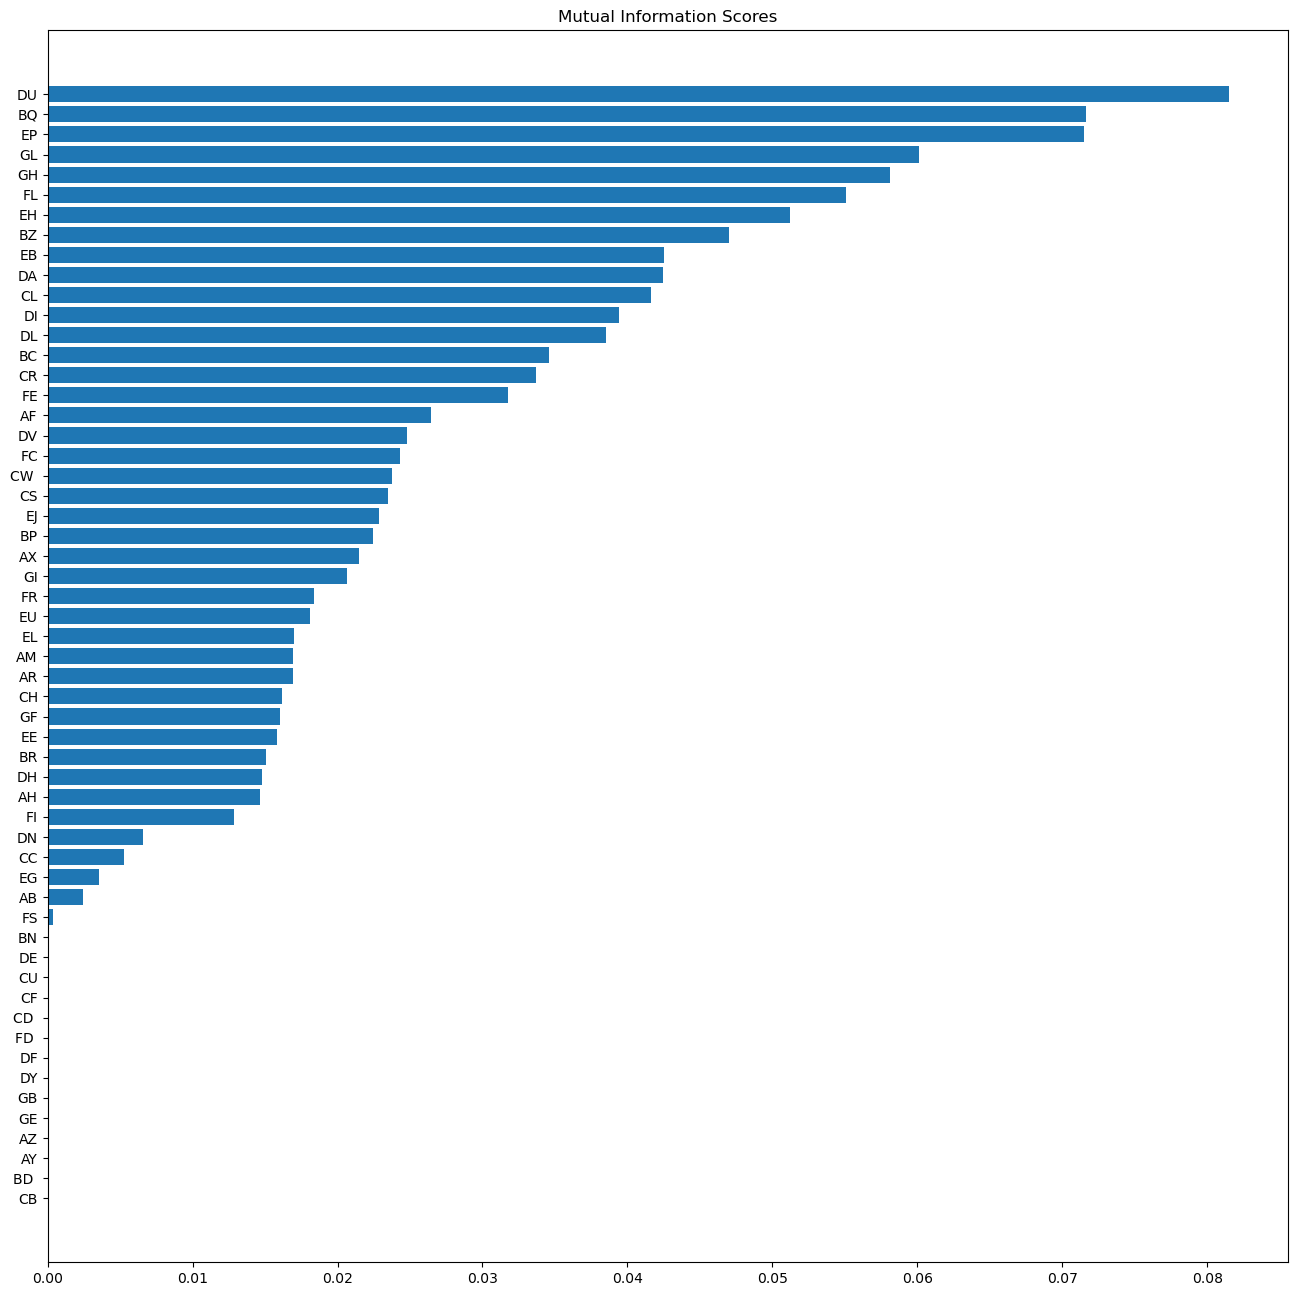

In [1009]:
#get the mutual information of features
def make_mi_scores(X: pd.DataFrame, y: pd.DataFrame, discrete_features: list):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(dpi=100, figsize=(16, 16))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



cols = list(X_train.columns)
cols.append("1")
X_transformed = X_train.fillna(0)
X_transformed["EJ"].replace(['A', 'B'], [0, 1], inplace=True)
discrete_features = X_transformed.dtypes == int
mi_scores = make_mi_scores(X_transformed, y_train, discrete_features)
bad_scores = list(mi_scores.index[i] for i, score in zip(range(len(mi_scores)),mi_scores) if score < 0.01)
plot_mi_scores(mi_scores)
print(f" Columns with MI equal zero: {bad_scores} --> total length: {len(bad_scores)}")
#--> dropping the unecessary columns

In [1010]:
# Building Pipeline
train, greeks, test, id_list = load_dataset(columns_drop=bad_scores)
print(f"dataset shape: {train.shape}")
X_train, X_valid, y_train, y_valid = split_data(train, 0.3)
preprocessor = build_pipeline(X_train)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model)
                        ])

#Fit the Model and make preds
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)
score = cross_val_score(pipeline, X_valid, y_valid, cv=5, scoring='accuracy')
print(f"Accuracy of {score}")

38
dataset shape: (617, 38)
Number of columns: 37
Accuracy of [0.92105263 0.91891892 0.89189189 0.97297297 0.86486486]
